In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
from matplotlib import pyplot as plt

In [41]:
# 训练集图像预处理、旋转图片、resize、正则化等操作
preprocess_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))    
])
# 测试集图像预处理resize、正则化等操作
preprocess_test = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
# 下载数据集
train_set = datasets.MNIST(root="./data", train=True, download=False, transform=preprocess_train)
test_set = datasets.MNIST(root="./data", train=False, download=False, transform=preprocess_test)
# 加载数据集
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [42]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 卷积层
        self.Sigmoid = nn.Sigmoid()  # Sigmoid
        self.maxpool1 = nn.MaxPool2d(2, 2)  # 最大池化层
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)  # 全连接
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.conv1(x)  # C1
        x = self.Sigmoid(x)
        x = self.maxpool1(x)  # S2
        x = self.conv2(x)  # C3
        x = self.maxpool2(x)  # S4
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))  # C5
        x = F.relu(self.fc2(x))  # F6
        x = self.fc3(x)  
        output = F.log_softmax(x, dim=1)  # output
        return output

In [43]:
# 创建模型、定义优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
def train(model, device, train_loader, optimizer, epoch):
    # 训练模型
    model.train()
    total = 0
    correct =0.0
    
    for iter, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 初始化梯度
        optimizer.zero_grad()
        outputs = model(inputs)
        # 计算损失和
        loss = F.cross_entropy(outputs, labels)
        # 获取预测结果
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        # 反向传播
        loss.backward()
        optimizer.step()
        if iter % 1000 == 0:
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

In [45]:
# 模型测试
def test(model, device, test_loader):
    model.eval()
    correct = 0.0
    test_loss = 0.0
    total = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            # 计算损失值
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            # 计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        
        print("loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

Train Epoch1 	 Loss: 2.293072, accuracy: 10.937500%
loss: 0.006508, accuracy: 93.640000%
Train Epoch2 	 Loss: 0.257832, accuracy: 93.750000%
loss: 0.003431, accuracy: 96.540000%
Train Epoch3 	 Loss: 0.124057, accuracy: 95.312500%
loss: 0.002917, accuracy: 97.260000%
Train Epoch4 	 Loss: 0.046330, accuracy: 98.437500%
loss: 0.002195, accuracy: 97.740000%
Train Epoch5 	 Loss: 0.044660, accuracy: 96.875000%
loss: 0.002499, accuracy: 97.430000%


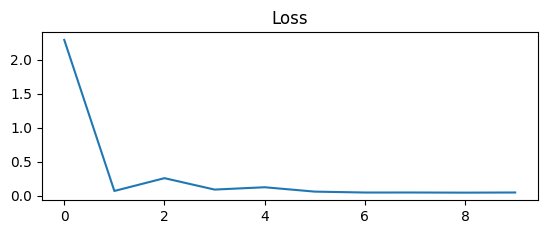

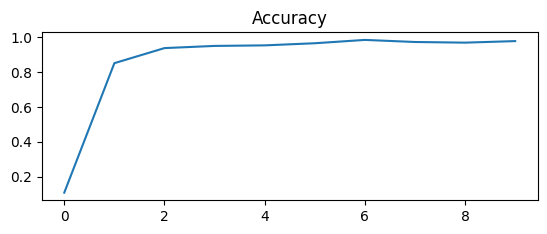

In [46]:
epoch = 5
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    loss, acc = train(model, device, train_loader, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test(model, device, test_loader)

# 可视化输出
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

In [47]:
print(model)
torch.save(model, 'model.pth') #保存模型

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (Sigmoid): Sigmoid()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


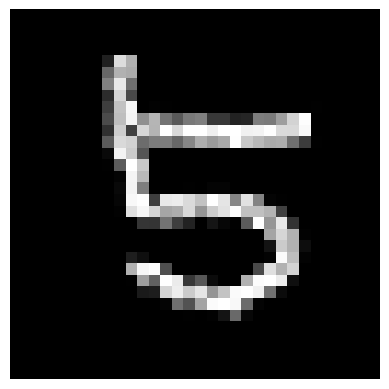

预测类别： 5


In [49]:
import cv2

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('model.pth') #加载模型
    model = model.to(device)
    model.eval()    
    
    # 读取要预测的图片
    image = cv2.imread("./test_image.jpg")
    image=cv2.resize(image, dsize=(32,32),interpolation=cv2.INTER_NEAREST)
    plt.imshow(image,cmap="gray") 
    plt.axis('off') 
    plt.show()
    
    # 导入图片
    trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 图片转为灰度图
    image = trans(image)
    image = image.to(device)
    image = image.unsqueeze(0) 
    
    # 预测 
    output = model(image)
    prob = F.softmax(output,dim=1)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    print("预测类别：",predict.item())